<a href="https://colab.research.google.com/github/Casualite/Neural_network_11th/blob/master/DIP2_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Apr 28 11:02:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import numpy as np
#import tensorflow_addons as tfa

In [ ]:
# def mask_generator(inputs, pool_size=2, strides=2):
#     return tf.nn.max_pool_with_argmax(input, ksize=pool_size, strides=strides, padding='SAME')

In [ ]:
# Define the encoder model
def encoder(input_tensor):
    # Convolutional layers
    l=[]
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    #l.append(mask_generator(x))

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    #l.append(mask_generator(x))

    x = tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    #l.append(mask_generator(x))

    x = tf.keras.layers.Conv2D(filters=512, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=5, padding='same', activation='relu')(x)
    x1 = tf.keras.layers.Conv2D(filters=512, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x1)
    #l.append(mask_generator(x))

    x = tf.keras.layers.Conv2D(filters=512, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=5, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=5, padding='same', activation='relu')(x)
    # Output of encoder
    encoded = x
    return encoded,x1

In [ ]:
def decoder(encoded,output_shape,conv_layer):
    # Deconvolutional layers
    x = tf.keras.layers.BatchNormalization()(encoded)
    x = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=5, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Concatenate([x,conv_layer])
    x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=5, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)

    # Output of decoder
    decoded = tf.keras.layers.Conv2DTranspose(output_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)
    return decoded

In [ ]:
def full_model(input_shape, bg_image_shape):
    input = tf.keras.layers.Input(shape=input_shape)
    encode,x1 = encoder(input)
    decode = decoder(encode,bg_image_shape,x1)
    output = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [bg_image_shape[0], bg_image_shape[1]]))(decode)
    return tf.keras.models.Model(inputs=input, outputs=output)


In [ ]:
#@title Default title text
batch_size = 16
num_epochs = 10
def preprocess_cdnet_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, (336, 336))
    # print(image)
    #image = tf.cast(image/255. ,tf.float32)
    return image

def load_gt(gt_path):
    image = tf.io.read_file(gt_path)
    image = tf.image.decode_png(image,channels=1)
    image = tf.image.resize(image, (336, 336))
    #print(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image = tf.cast(image/255. ,tf.float32)
    return image

def generate_combined(image_paths):
    prev=preprocess_cdnet_image('/content/drive/MyDrive/baseline/highway/input/in000469.jpg')
    back=preprocess_cdnet_image('/content/drive/MyDrive/baseline/highway/in000471.jpg')
    for x in range(len(image_paths)):
        image = preprocess_cdnet_image(image_paths[x])
        #image1=tf.stack([image,prev,back])
        image1=tf.concat([image,prev,back],2)
        prev=image
        np.save('/content/drive/MyDrive/baseline/highway/Updated_dataset1/'+image_paths[x][46:]+'.npy',image1.numpy())


def generate_gt(gt_paths):
    for x in range(len(gt_paths)):
         np.save('/content/drive/MyDrive/baseline/highway/gt_npy/'+gt_paths[x][-12:-4]+'.npy',load_gt(gt_paths[x]).numpy())

In [ ]:
import os
data_path_train = '/content/drive/MyDrive/baseline'
train_path = os.path.join(data_path_train, 'highway', 'input')
train_files = sorted(os.listdir(train_path))
train_files = [os.path.join(train_path, f) for f in train_files][470:]


gt_path = os.path.join(data_path_train, 'highway', 'groundtruth')
gt_files = sorted(os.listdir(gt_path))
gt_files = [os.path.join(gt_path, f) for f in gt_files][470:]

In [ ]:
import os
import cv2
def load_from_drive(path):
    data_path_train = path
    train_files = sorted(os.listdir(data_path_train))
    train_files = [os.path.join(data_path_train, f) for f in train_files]
    return(train_files)


In [ ]:
#generate_combined(train_files)
generate_gt(gt_files)

In [ ]:
generate_combined(train_files)

In [ ]:
#@title Default title text
new_ds=load_from_drive('/content/drive/MyDrive/baseline/highway/Updated_dataset1/')
gt_ds=load_from_drive('/content/drive/MyDrive/baseline/highway/gt_npy/')

In [ ]:
len(gt_ds)

1230

In [ ]:
def map_func(train,gt):
    t=np.load(train)
    g=np.load(gt)
    return(t,g)
def _fixup_shape(images, gt):
    images.set_shape([336, 336, 3])
    gt.set_shape([336, 336, 1]) # I have 19 classes
    # weights.set_shape([None])
    return images, gt

dataset = tf.data.Dataset.from_tensor_slices((new_ds,gt_ds))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.float32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(_fixup_shape)
dataset = dataset.shuffle(1000).batch(16)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
i=5
c=0
for e in dataset:
  if(c==i):
    break
  print(e[0].shape,e[1].shape)
  c+=1

(16, 336, 336, 3) (16, 336, 336, 1)
(16, 336, 336, 3) (16, 336, 336, 1)
(16, 336, 336, 3) (16, 336, 336, 1)
(16, 336, 336, 3) (16, 336, 336, 1)
(16, 336, 336, 3) (16, 336, 336, 1)


In [ ]:
model = full_model([336, 336, 3], [336, 336, 1])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="mean_squared_error", metrics=["accuracy"])
model.summary()

TypeError: ignored

In [ ]:
model.fit(dataset, epochs=5,batch_size=16,shuffle=True)

Epoch 1/5
77/77 [==============================] - 128s 2s/step - loss: 4421.4482 - accuracy: 0.8360
Epoch 2/5
77/77 [==============================] - 95s 1s/step - loss: 4421.4531 - accuracy: 0.8293
Epoch 3/5
77/77 [==============================] - 95s 1s/step - loss: 4421.4321 - accuracy: 0.8501
Epoch 4/5
77/77 [==============================] - 95s 1s/step - loss: 4421.4565 - accuracy: 0.8278
Epoch 5/5
77/77 [==============================] - 94s 1s/step - loss: 4421.4414 - accuracy: 0.8431


In [ ]:
model.save_weights('/content/drive/MyDrive/baseline/checkpoints/')

In [ ]:
model.load_weights('/content/drive/MyDrive/baseline/checkpoints/')

In [ ]:
model.fit(dataset, epochs=5,batch_size=16,shuffle=True)

In [ ]:
i=5
c=0
y=None
X=None
for e in dataset:
  X=e[0]
  y=model.predict(e[0])
  break

1/1 [==============================] - 24s 24s/step


In [ ]:
X.shape,y.shape

(TensorShape([16, 336, 336, 3]), (16, 336, 336, 1))

In [ ]:
np.squeeze(np.uint8(y[5]*255)).T

NameError: ignored

In [ ]:
X[1].numpy().T[1]

array([[0.30217254, 0.25735912, 0.20259038, ..., 0.47013727, 0.38137594,
        0.30519336],
       [0.10919465, 0.11847743, 0.13132899, ..., 0.42592368, 0.31427574,
        0.22144823],
       [0.12543952, 0.12111823, 0.11499076, ..., 0.38551128, 0.2627269 ,
        0.16664511],
       ...,
       [0.3006406 , 0.46223578, 0.6319638 , ..., 0.34426045, 0.37526432,
        0.41703668],
       [0.28875715, 0.45232624, 0.62608796, ..., 0.41977665, 0.44723186,
        0.4794007 ],
       [0.2851161 , 0.4486852 , 0.62244695, ..., 0.43277985, 0.40770036,
        0.39201573]], dtype=float32)

In [ ]:
from PIL import Image
import numpy as np
img1=Image.fromarray(np.uint8(X[5].numpy().T[0]*255), 'L')
img2=Image.fromarray(np.squeeze(np.uint8(y[5]*255)).T, 'L')

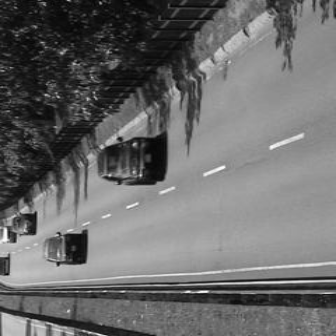

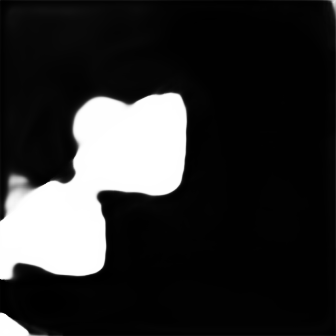

In [ ]:
img1.show()
img2.show()